In [ ]:
import os
import imageio.v2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from google.colab import drive
import zstandard as zstd # Import zstandard

In [ ]:
drive.mount('/content/drive')
test_data_path = '/content/drive/MyDrive/Progetto Compressione dati/Dataset RGB/100 images'
num_lightfields = 25
num_cameras_x = 2
num_cameras_y = 2
height, width = 512, 512
MODEL_SAVE_PATH = '/content/drive/MyDrive/Progetto Compressione dati/200 epoche e 200 immagini_512x512/compressione512x512_200images_200epoche.keras'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class LightfieldDataset(Dataset):
    def __init__(self, data_path, num_lightfields, num_cameras_x, num_cameras_y):
        self.num_lightfields = num_lightfields
        self.num_cameras_x = num_cameras_x
        self.num_cameras_y = num_cameras_y
        self.data_path = data_path

    def __len__(self):
        return self.num_lightfields

    def __getitem__(self, idx):
        lightfield = torch.zeros(3, height, width, self.num_cameras_y, self.num_cameras_x)
        for x in range(self.num_cameras_x):
            for y in range(self.num_cameras_y):
                img_path = os.path.join(self.data_path, f'image{idx}_x{x}_y{y}.png')
                if not os.path.exists(img_path):
                    raise FileNotFoundError(f"File non trovato: {img_path}")
                view = Image.open(img_path).resize((width, height))
                view = torch.Tensor(np.array(view)).permute(2, 0, 1) / 255.0
                lightfield[:, :, :, y, x] = view
        lightfield = lightfield.view(3, height, width, -1).permute(3, 1, 2, 0)
        return lightfield

In [ ]:
def visualize_reconstruction_and_compression(model, dataloader, num_images=4):
    encoder = models.Model(inputs=model.input, outputs=model.get_layer(index=len(model.layers)//2).output)
    decoder = models.Model(inputs=model.get_layer(index=len(model.layers)//2).output, outputs=model.output)

    fig, axs = plt.subplots(3, num_images, figsize=(15, 15))

    for batch in dataloader:
        batch_np = batch.numpy()

        compressed = encoder.predict(batch_np)

        compressed_bytes = compressed.tobytes()
        compressed_zstd = zstd.compress(compressed_bytes)

        reconstructed = decoder.predict(compressed) # Decoder uses the uncompressed encoded representation

        print(f"Dimensione delle immagini di partenza: {batch_np.shape}")
        print(f"Dimensione delle immagini compresse (autoencoder output): {compressed.shape}")
        print(f"Dimensione delle immagini compresse (zstd): {len(compressed_zstd)} bytes") # size of zstd compressed object, accurate size using len()
        print(f"Dimensione delle immagini decompresse: {reconstructed.shape}")

        original_size_kb = batch_np.nbytes / 1024
        compressed_size_kb = compressed.nbytes / 1024
        compressed_size_kb_zstd = len(compressed_zstd) / 1024.0 # Accurate size of zstd compressed data
        reconstructed_size_kb = reconstructed.nbytes / 1024

        compression_ratio_autoencoder = (((compressed_size_kb * 100) / original_size_kb) - 100) * -1
        compression_ratio_zstd = (((compressed_size_kb_zstd * 100) / original_size_kb) - 100) * -1


        num_views = num_cameras_x * num_cameras_y
        single_image_original_size_kb = original_size_kb / num_views
        single_image_compressed_size_kb = compressed_size_kb / num_views
        single_image_compressed_size_kb_zstd = compressed_size_kb_zstd / num_views
        single_image_reconstructed_size_kb = reconstructed_size_kb / num_views

        # Stampa dei risultati
        print(f"Peso della Light Field Image originale: {original_size_kb:.2f} KB")
        print(f"Peso della Light Field Image compressa (senza entropia): {compressed_size_kb:.2f} KB")
        print(f"Peso della Light Field Image compressa (con entropia): {compressed_size_kb_zstd:.2f} KB")
        print(f"Peso della Light Field Image ricostruita: {reconstructed_size_kb:.2f} KB")
        print(f"Rapporto di compressione Light Field Image (senza entropia): {compression_ratio_autoencoder:.2f}%")
        print(f"Rapporto di compressione Light Field Image (con entropia): {compression_ratio_zstd:.2f}%")

        print(f"Peso della singola immagine originale: {single_image_original_size_kb:.2f} KB")
        print(f"Peso della singola immagine compressa (senza entropia): {single_image_compressed_size_kb:.2f} KB")
        print(f"Peso della singola immagine compressa (con entropia): {single_image_compressed_size_kb_zstd:.2f} KB")
        print(f"Peso della singola immagine ricostruita: {single_image_reconstructed_size_kb:.2f} KB\n")

        for i in range(num_images):
            # Immagini originali
            axs[0, i].imshow(batch_np[0, i])
            axs[0, i].set_title("Originale")
            axs[0, i].axis("off")

            compressed_view = np.mean(compressed[0, i], axis=-1) # Visualize the autoencoder compressed output
            axs[1, i].imshow(compressed_view, cmap='viridis')
            axs[1, i].set_title("Compressa")
            axs[1, i].axis("off")

            axs[2, i].imshow(np.clip(reconstructed[0, i], 0, 1))
            axs[2, i].set_title("Ricostruita")
            axs[2, i].axis("off")

        plt.tight_layout()
        plt.show()
        break

In [ ]:
def calculate_dataset_metrics(model, dataloader):
    encoder = models.Model(inputs=model.input, outputs=model.get_layer(index=len(model.layers)//2).output)
    decoder = models.Model(inputs=model.get_layer(index=len(model.layers)//2).output, outputs=model.output)

    total_original_size = 0
    total_compressed_size_autoencoder = 0
    total_compressed_size_zstd = 0
    total_reconstructed_size = 0
    total_psnr = 0
    total_ssim = 0
    num_images_processed = 0

    for batch in dataloader:
        batch_np = batch.numpy()
        compressed_batch = encoder.predict(batch_np)

        compressed_bytes = compressed_batch.tobytes()
        compressed_zstd_batch = zstd.compress(compressed_bytes)

        reconstructed_batch = decoder.predict(compressed_batch)

        total_original_size += batch_np.nbytes
        total_compressed_size_autoencoder += compressed_batch.nbytes
        total_compressed_size_zstd += len(compressed_zstd_batch)
        total_reconstructed_size += reconstructed_batch.nbytes

        for i in range(batch_np.shape[1]):
            original_image = batch_np[0, i]
            reconstructed_image = reconstructed_batch[0, i]

            psnr_value = psnr(original_image, reconstructed_image)
            ssim_value = ssim(
                original_image,
                reconstructed_image,
                win_size=5,
                multichannel=True,
                channel_axis=-1,
                data_range=1.0
            )
            total_psnr += psnr_value
            total_ssim += ssim_value
            num_images_processed += 1

    avg_psnr = total_psnr / num_images_processed
    avg_ssim = total_ssim / num_images_processed
   compression_ratio_autoencoder = total_compressed_size_autoencoder / total_original_size
compression_ratio_zstd = total_compressed_size_zstd / total_original_size



    print(f"------------------------Dataset Metrics------------------------")
    print(f"Dimensione totale immagini originali: {total_original_size / 1024:.2f} KB")
    print(f"Dimensione totale immagini compresse (senza entropia): {total_compressed_size_autoencoder / 1024:.2f} KB")
    print(f"Dimensione totale immagini compresse (con entropia): {total_compressed_size_zstd / 1024:.2f} KB")
    print(f"Dimensione totale immagini ricostruite: {total_reconstructed_size / 1024:.2f} KB")
    print(f"Rapporto di compressione medio sul dataset (senza entropia): {compression_ratio_autoencoder:.4f}")
    print(f"Rapporto di compressione medio sul dataset (con entropia): {compression_ratio_zstd:.4f}")
    print(f"PSNR medio sul dataset: {avg_psnr:.2f} dB")
    print(f"SSIM medio sul dataset: {avg_ssim:.4f}")
    print(f"---------------------------------------------------------------")

In [ ]:
loaded_autoencoder = models.load_model(MODEL_SAVE_PATH)
test_dataset = LightfieldDataset(data_path=test_data_path, num_lightfields=num_lightfields, num_cameras_x=num_cameras_x, num_cameras_y=num_cameras_y)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Dimensione delle immagini di partenza: (1, 4, 512, 512, 3)
Dimensione delle immagini compresse (autoencoder output): (1, 4, 64, 64, 3)
Dimensione delle immagini compresse (zstd): 174342 bytes
Dimensione delle immagini decompresse: (1, 4, 512, 512, 3)
Peso della Light Field Image originale: 12288.00 KB
Peso della Light Field Image compressa (senza entropia): 192.00 KB
Peso della Light Field Image compressa (con entropia): 170.26 KB
Peso della Light Field Image ricostruita: 12288.00 KB
Rapporto di compressione Light Field Image (senza entropia): 98.44%
Rapporto di compressione Light Field Image (con entropia): 98.61%
Peso della singola immagine originale: 3072.00 KB
Peso della singola immagine compressa (senza entropia): 48.00 KB
Peso della singola immagine compressa (con entropia): 42.56 KB
Peso della singola immagine ricostruita: 3072.00 KB



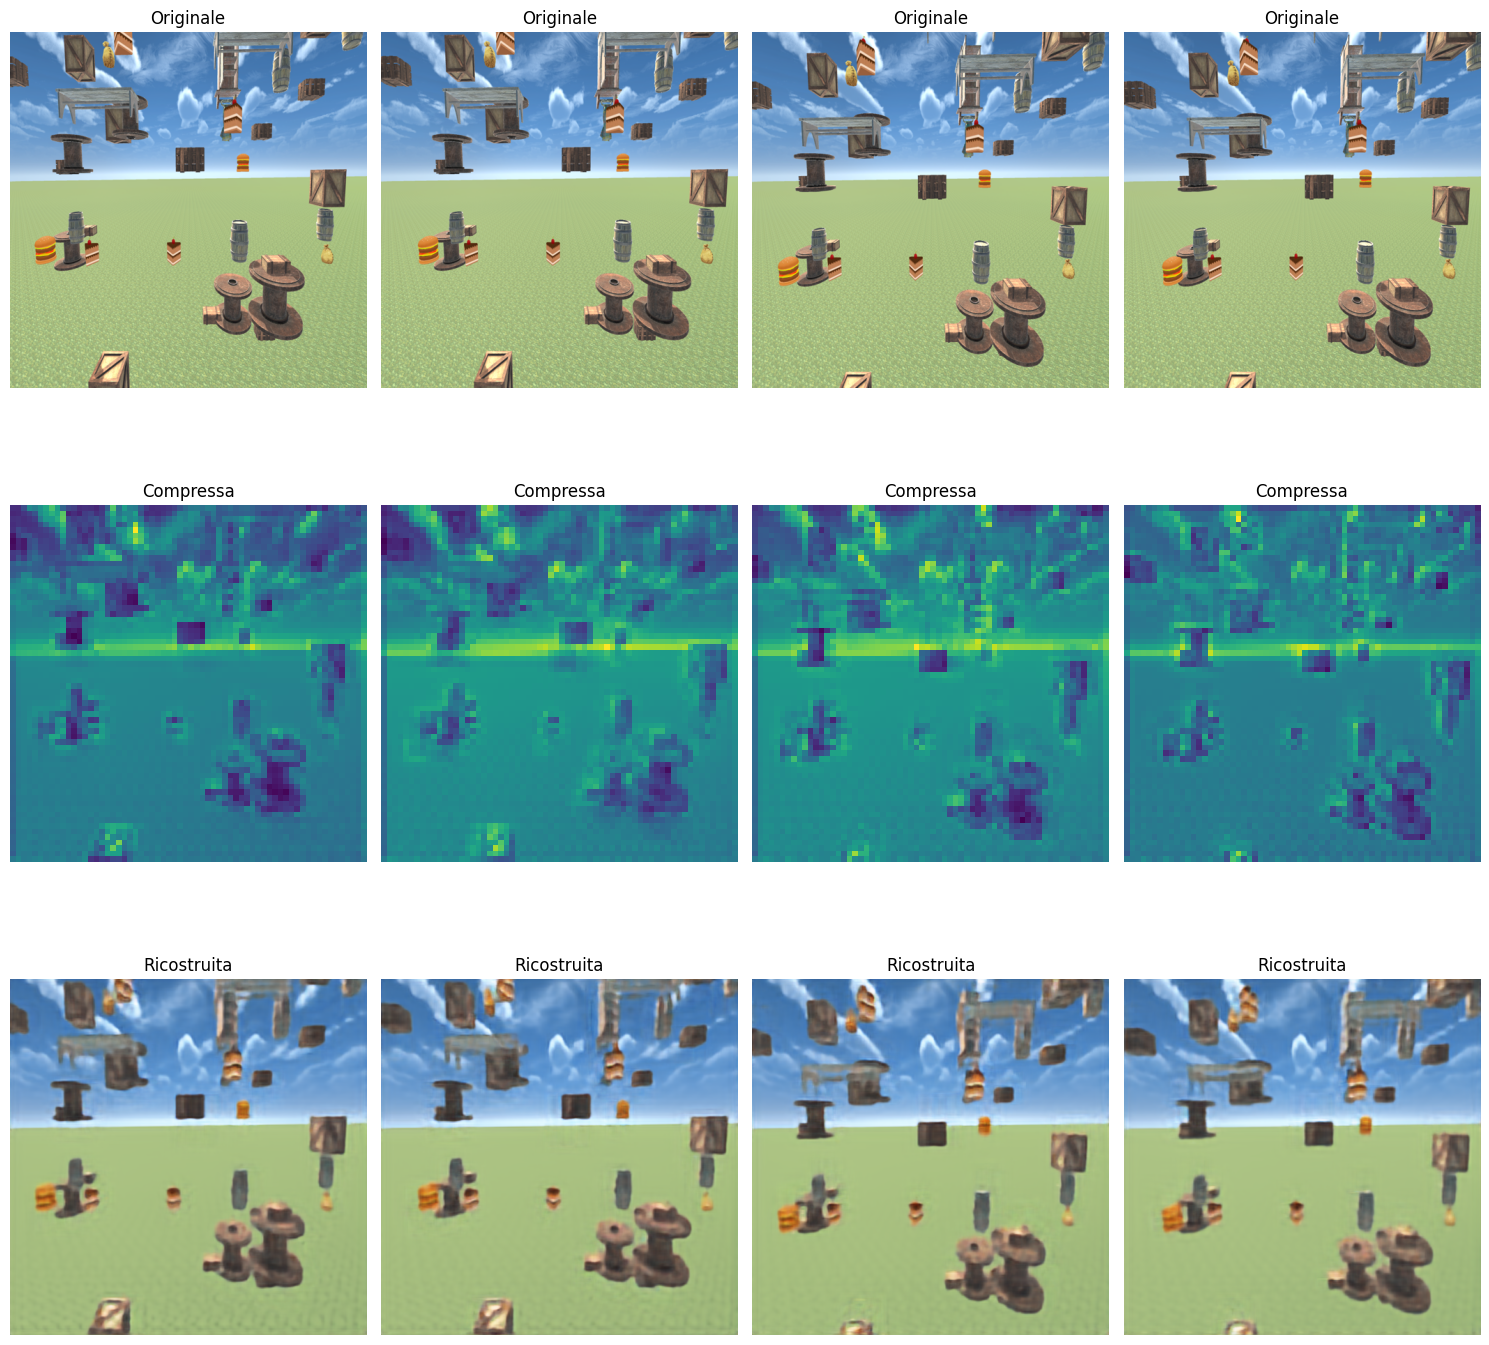

In [ ]:
visualize_reconstruction_and_compression(loaded_autoencoder, test_loader, num_images=4)

In [ ]:
calculate_dataset_metrics(loaded_autoencoder, test_loader)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/ste